In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import sys
sys.path.append("../SUBMIT")
from PKGS import us_starter

### haafor packages ###
from hf.service.module_directory import ModuleDirectory
module_directory = ModuleDirectory()
from hf.lib.corr_check import CorrCheck
import hf.pm.simulator as simulator
from hf.pm.summary import show_summary
from hf.pm.operation import GroupNeutral, Remap
from hf.framework.hfclndr import HFCLNDR

### custom packages ###
import matrixOp as mp
import alpha_operation
from PKGS.utils import funda_show as show
from PKGS import us_starter,alpha_operation,utils

/usr/local/anaconda2/lib/python2.7/site-packages/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
univ1000,univ1000_id_list,price_return,sector,industry,sub_industry,date_list\
 = us_starter.starter(20100101,20131231)

In [3]:
total_df = pd.read_csv("total_df.csv")

In [4]:
used_df = total_df[total_df.HFSID.isin(univ1000_id_list)].reset_index(drop=True)
used_df.sort_values('UPDATED_DAY',inplace=True)
used_df['UPDATED_DAY'] = date_list[np.searchsorted(date_list,used_df.UPDATED_DAY,'right')-1]

In [5]:
lv2_df = used_df['score'].groupby([used_df.UPDATED_DAY,used_df.HFSID]).mean().unstack('HFSID')

In [6]:
append_idx = set(date_list).difference(set(lv2_df.index))
append_df = \
pd.DataFrame(np.full((len(append_idx),lv2_df.shape[1]),fill_value=np.nan),index=append_idx,columns=lv2_df.columns)

In [7]:
concat_df = pd.concat((lv2_df,append_df))

In [8]:
for col in univ1000_id_list : 
    if col not in concat_df.columns : 
        concat_df[col] = np.nan

In [9]:
concat_df.sort_index(inplace=True)
lv2_df = concat_df.loc[:,univ1000_id_list]

In [10]:
signal = alpha_operation.decay_ffill(lv2_df,2,50).values

In [16]:
signal[np.isnan(signal)] = 0.

In [18]:
alpha = signal.astype(np.float64).copy()
univSignal_m = np.copy(univ1000) 
univSignal_m[np.where(~np.isfinite(alpha))] = False 

# Operation # 
industry = np.copy(sub_industry)
# masking
alpha[ ~univSignal_m ] = np.nan 
industry[ ~univSignal_m ] = np.nan
alpha1 = alpha.copy()

groupneutral = GroupNeutral(univSignal_m, industry)
alpha2 = groupneutral.group_neutralize(alpha1)
alpha2[~univSignal_m] = np.nan

alpha2 = pd.DataFrame(alpha2).shift(0).values
alpha2[~univSignal_m] = np.nan

remap = Remap(univSignal_m)
alpha3 = remap.remap(alpha2)
alpha3[ ~univSignal_m ] = np.nan

alpha4 = alpha3.copy()
alpha5 = pd.DataFrame(alpha4).shift(1).values

alpha = np.copy(alpha5[:])

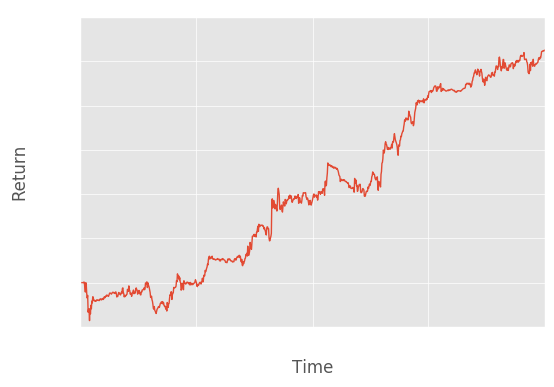

          IR  Return(%)  MDD(%)  Turnover(%) Concent50 Concent90
2010   0.004       0.69    8.72        47.47         4        20
2011   0.088      17.67    5.38        47.38         4        24
2012   0.137      24.03    7.48        40.77         4        19
2013   0.078      10.30    4.76        39.14         3        22
Total  0.077      13.28    8.72        43.69         4        21


In [12]:
sim = simulator.Simulator(price_return=price_return[:])
pnl, tvr = sim.simulate(alpha, book_size=20e6)
statDix = 1
validDates_v = np.copy(date_list)
show_summary(alpha[statDix:],pnl[statDix:],tvr[statDix:],validDates_v[statDix:])

In [13]:
corr_check = CorrCheck(delay='1')
display(corr_check.check_corr(pnl, start_date = validDates_v[0], end_date = validDates_v[-1]))

[INFO] Load Correlation Check
[INFO] module_type=PM, region=US, delay=1


,Corr,IR,MDD,tvr,concent90,concent50,return_1yr,category,birthday,author
zttan_usa_h.190325.7.0311.bie|univ2000_wo_otc_sbc0.1|remap_borrowing_cost,0.20,0.08,2.15,43.18,900.00,270.00,2.73,price,20190325,[zttan]
zttan_usa_h.190318.7.0285.bhk|univ2000_wo_otc_sbc0.1|remap_borrowing_cost,0.19,0.10,2.13,42.98,894.00,265.00,3.15,price,20190318,[zttan]
zttan_usa_h.190320.2.0292.bhr|univ2000_wo_otc_sbc0.1|remap_borrowing_cost,0.19,0.07,2.43,48.70,884.00,258.00,2.42,price,20190320,[zttan]
zttan_usa_h.190324.1.0297.bhw|univ2000_wo_otc_sbc0.1|remap_borrowing_cost,0.19,0.10,1.89,44.44,894.00,266.00,3.11,price,20190324,[zttan]
zttan_usa_h.190428.4.0331.bef|univ2000_wo_otc_sbc0.1|remap_borrowing_cost,0.19,0.08,3.35,46.29,865.00,230.00,2.83,price,20190428,[zttan]
jaekyunkim_usa_h.181202.2.fs.wc.pr.qa.05|univ1000_wo_otc_sbc0.1|remap_borrowing_cost,-0.15,0.07,5.87,9.65,354.00,49.00,5.06,earnings_call,20181202,[jaekyunkim]
sylee_usa_h.171115.46.NN.SI.002|univ2000_wo_otc_sbc0.1|remap_borrowing_cost,-0.15,0.07,3.20,31.44,"1,256.00",333.00,2.53,short_interest,20171115,[sylee]
dltrinh_usa_h.180216.22.hff22|univ2000_wo_otc_sbc0.1|remap_borrowing_cost,-0.15,0.08,1.38,7.62,"1,070.00",410.00,1.33,fundamental,20180216,[dltrinh]
jaehochoi_usa_h.190301.4.ir.yr.reversion.344|univ1000_wo_otc_sbc0.1|remap_borrowing_cost,-0.16,0.04,2.45,21.88,753.00,214.00,1.07,reversion,20190220,[jaehochoi]
zqbok_usa_h.180424.4.hff.cfo.04d|R2_wo_otc|remap,-0.19,0.06,19.62,55.18,327.00,25.00,4.18,fundamental_trend,20180423,[zqbok]
